Bitcoin Price Prediction Model Using a Regression Model
Jacqueline Develder 

In [45]:
## import libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import matplotlib.pyplot as plt

In [46]:
## load data 

def load_data():
    amo_chainlets = pd.read_csv("AmoChainletsInTime.txt", sep='\t')
    occ_chainlets = pd.read_csv("OccChainletsInTime.txt", sep='\t')
    price_data = pd.read_csv("pricedBitcoin2009-2018.csv")
    
    price_data['date'] = pd.to_datetime(price_data['date'])
    price_data['year'] = price_data['date'].dt.year
    price_data['day'] = price_data['date'].dt.dayofyear
    
    chainlet_cols = [col for col in amo_chainlets.columns if ':' in col]
    amo_rename = {col: f"{col}_amo" for col in chainlet_cols}
    occ_rename = {col: f"{col}_occ" for col in chainlet_cols}
    
    amo_chainlets = amo_chainlets.rename(columns=amo_rename)
    occ_chainlets = occ_chainlets.rename(columns=occ_rename)
    
    amo_merge_cols = ['year', 'day'] + list(amo_rename.values())
    merged_data = price_data.merge(
        amo_chainlets[amo_merge_cols],
        on=["year", "day"],
        how="left"
    )
    
    occ_merge_cols = ['year', 'day'] + list(occ_rename.values())
    merged_data = merged_data.merge(
        occ_chainlets[occ_merge_cols],
        on=["year", "day"],
        how="left"
    )
    
    return merged_data

In [47]:
## filter and process data 

def create_features(df, n_lags=3):
    features_df = df.copy()
    
    for i in range(1, n_lags + 1):
        features_df[f'price_lag_{i}'] = features_df['price'].shift(i)
    
    windows = [1, 5, 7]
    for window in windows:
        features_df[f'price_ma_{window}'] = features_df['price'].rolling(window=window).mean()
        features_df[f'price_std_{window}'] = features_df['price'].rolling(window=window).std()
    
    features_df['price_momentum'] = features_df['price'] / features_df['price'].shift(5) - 1
    
    basic_patterns = ['1:1', '1:2', '2:1', '2:2']
    for pattern in basic_patterns:
        amo_col = f"{pattern}_amo"
        occ_col = f"{pattern}_occ"
        if amo_col in features_df.columns and occ_col in features_df.columns:
            features_df[f'ratio_{pattern}'] = features_df[amo_col] / (features_df[occ_col] + 1)
    
    return features_df

In [48]:
## evaluate best model 
## https://medium.com/@msoczi/ridge-regression-step-by-step-introduction-with-example-0d22dddb7d54

def train_ridge_model(X_train, X_test, y_train, y_test):
    alphas = np.logspace(-3, 2, 20)
    best_alpha = None
    best_rmse = float('inf')
    best_model = None
    
    tscv = TimeSeriesSplit(n_splits=3)
    
    for alpha in alphas:
        model = Ridge(alpha=alpha)
        cv_scores = []
        
        for train_idx, val_idx in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train[train_idx], X_train[val_idx]
            y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            model.fit(X_train_cv, y_train_cv)
            predictions = model.predict(X_val_cv)
            rmse = np.sqrt(mean_squared_error(y_val_cv, predictions))
            cv_scores.append(rmse)
        
        mean_rmse = np.mean(cv_scores)
        if mean_rmse < best_rmse:
            best_rmse = mean_rmse
            best_alpha = alpha
    
    # train final model with best alpha
    final_model = Ridge(alpha=best_alpha)
    final_model.fit(X_train, y_train)
    
    predictions = final_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    
    return final_model, predictions, test_rmse

In [49]:
## training data split 

def prepare_train_test_data(df, test_start_date='2017-12-01'):
    # only select features that don't leak future information
    feature_cols = [col for col in df.columns 
                   if col.startswith(('price_lag_', 'returns_', 'ratio_', 'momentum_', 'volatility_'))
                   and col != 'price']
        
    train_data = df[df['date'] < test_start_date].copy()
    test_data = df[df['date'] >= test_start_date].copy()
    
    n_lags = 7  
    train_data = train_data.iloc[:-n_lags]
    
    X_train = train_data[feature_cols].copy()
    y_train = train_data['price'].copy()
    X_test = test_data[feature_cols].copy()
    y_test = test_data['price'].copy()
    
    for df in [X_train, X_test]:
        df.ffill(inplace=True)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, test_data['date'], feature_cols

In [50]:
## execution function


def execute():
    print("Step 1: Loading data...")
    merged_data = load_data()
    
    print("Step 2: Creating features...")
    feature_df = create_features(merged_data)
    
    print("Step 3: Filtering to 2017...")
    feature_df = feature_df[feature_df['date'] >= '2017-01-01'].copy()
    print(f"Records for 2017: {len(feature_df)}")
    
    X_train, X_test, y_train, y_test, test_dates, feature_cols = prepare_train_test_data(
        feature_df, 
        test_start_date='2017-12-01'
    )
    
    print("Step 4: Training Ridge model...")
    model, predictions, rmse = train_ridge_model(X_train, X_test, y_train, y_test)
    
    predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions
    })
    
    predictions_df.to_csv('december_2017_predictions.csv', index=False)
    print("Predictions saved to 'december_2017_predictions.csv'")
    
    full_predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions,
        'actual_price': y_test.values,
        'absolute_error': np.abs(predictions - y_test.values),
        'percentage_error': np.abs((predictions - y_test.values) / y_test.values) * 100
    })
    
    print("Prediction Summary:")
    print(f"RSME: ${rmse}")
    print(f"Average Absolute Error: ${full_predictions_df['absolute_error'].mean():.2f}")
    print(f"Median Absolute Error: ${full_predictions_df['absolute_error'].median():.2f}")
    print(f"Average Percentage Error: {full_predictions_df['percentage_error'].mean():.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Price', color='pink')
    plt.plot(test_dates, predictions, label='Predicted Price', color='purple')
    plt.title('Bitcoin Price Prediction - December 2017')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return full_predictions_df, model, rmse

In [50]:
## execution function


def execute():
    print("Step 1: Loading data...")
    merged_data = load_data()
    
    print("Step 2: Creating features...")
    feature_df = create_features(merged_data)
    
    print("Step 3: Filtering to 2017...")
    feature_df = feature_df[feature_df['date'] >= '2017-01-01'].copy()
    print(f"Records for 2017: {len(feature_df)}")
    
    X_train, X_test, y_train, y_test, test_dates, feature_cols = prepare_train_test_data(
        feature_df, 
        test_start_date='2017-12-01'
    )
    
    print("Step 4: Training Ridge model...")
    model, predictions, rmse = train_ridge_model(X_train, X_test, y_train, y_test)
    
    predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions
    })
    
    predictions_df.to_csv('december_2017_predictions.csv', index=False)
    print("Predictions saved to 'december_2017_predictions.csv'")
    
    full_predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions,
        'actual_price': y_test.values,
        'absolute_error': np.abs(predictions - y_test.values),
        'percentage_error': np.abs((predictions - y_test.values) / y_test.values) * 100
    })
    
    print("Prediction Summary:")
    print(f"RSME: ${rmse}")
    print(f"Average Absolute Error: ${full_predictions_df['absolute_error'].mean():.2f}")
    print(f"Median Absolute Error: ${full_predictions_df['absolute_error'].median():.2f}")
    print(f"Average Percentage Error: {full_predictions_df['percentage_error'].mean():.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Price', color='pink')
    plt.plot(test_dates, predictions, label='Predicted Price', color='purple')
    plt.title('Bitcoin Price Prediction - December 2017')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return full_predictions_df, model, rmse

In [50]:
## execution function


def execute():
    print("Step 1: Loading data...")
    merged_data = load_data()
    
    print("Step 2: Creating features...")
    feature_df = create_features(merged_data)
    
    print("Step 3: Filtering to 2017...")
    feature_df = feature_df[feature_df['date'] >= '2017-01-01'].copy()
    print(f"Records for 2017: {len(feature_df)}")
    
    X_train, X_test, y_train, y_test, test_dates, feature_cols = prepare_train_test_data(
        feature_df, 
        test_start_date='2017-12-01'
    )
    
    print("Step 4: Training Ridge model...")
    model, predictions, rmse = train_ridge_model(X_train, X_test, y_train, y_test)
    
    predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions
    })
    
    predictions_df.to_csv('december_2017_predictions.csv', index=False)
    print("Predictions saved to 'december_2017_predictions.csv'")
    
    full_predictions_df = pd.DataFrame({
        'date': test_dates,
        'predicted_price': predictions,
        'actual_price': y_test.values,
        'absolute_error': np.abs(predictions - y_test.values),
        'percentage_error': np.abs((predictions - y_test.values) / y_test.values) * 100
    })
    
    print("Prediction Summary:")
    print(f"RSME: ${rmse}")
    print(f"Average Absolute Error: ${full_predictions_df['absolute_error'].mean():.2f}")
    print(f"Median Absolute Error: ${full_predictions_df['absolute_error'].median():.2f}")
    print(f"Average Percentage Error: {full_predictions_df['percentage_error'].mean():.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Price', color='pink')
    plt.plot(test_dates, predictions, label='Predicted Price', color='purple')
    plt.title('Bitcoin Price Prediction - December 2017')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return full_predictions_df, model, rmse

Step 1: Loading data...
Step 2: Creating features...
Step 3: Filtering to 2017...
Records for 2017: 365
Step 4: Training Ridge model...
Predictions saved to 'december_2017_predictions.csv'
Prediction Summary:
RSME: $1103.9702356170656
Average Absolute Error: $859.98
Median Absolute Error: $693.77
Average Percentage Error: 5.55%


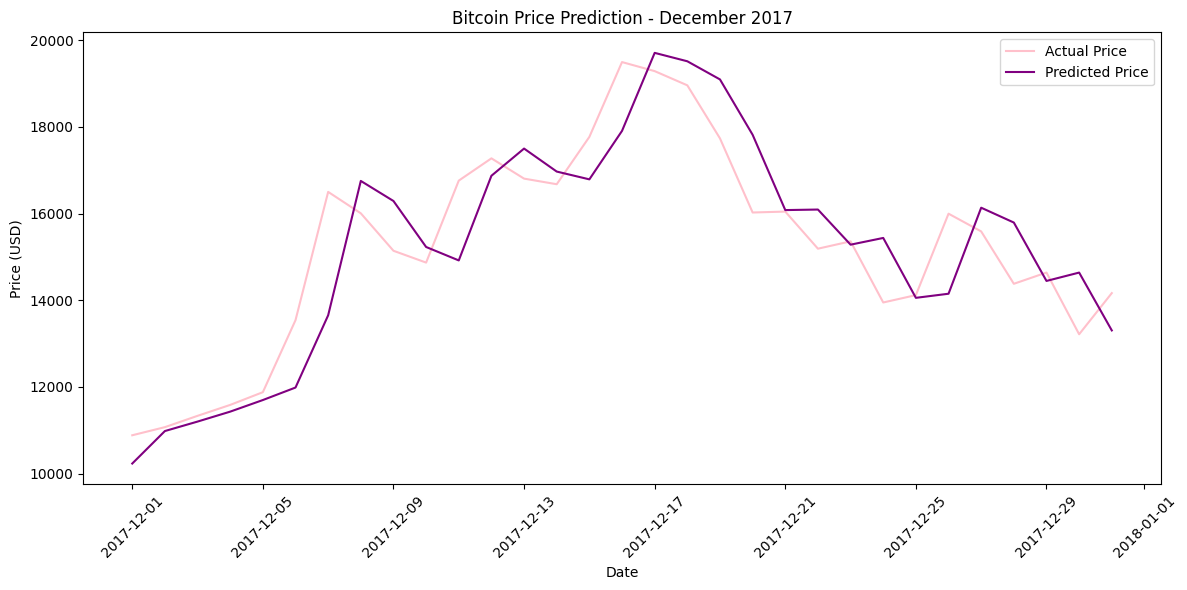

(           date  predicted_price  actual_price  absolute_error  \
 2373 2017-12-01     10231.188370   10883.91200      652.723630   
 2374 2017-12-02     10981.454783   11071.36833       89.913547   
 2375 2017-12-03     11199.997123   11332.62200      132.624877   
 2376 2017-12-04     11429.510846   11584.83000      155.319154   
 2377 2017-12-05     11697.104498   11878.43333      181.328832   
 2378 2017-12-06     11985.617738   13540.98000     1555.362262   
 2379 2017-12-07     13653.612023   16501.97167     2848.359647   
 2380 2017-12-08     16755.039390   16007.43667      747.602720   
 2381 2017-12-09     16291.841035   15142.83415     1149.006885   
 2382 2017-12-10     15230.212758   14869.80500      360.407758   
 2383 2017-12-11     14919.907246   16762.11667     1842.209424   
 2384 2017-12-12     16874.094769   17276.39333      402.298561   
 2385 2017-12-13     17502.135995   16808.36667      693.769325   
 2386 2017-12-14     16971.353701   16678.89200      292.46170

In [51]:
execute()